# Análisis de los usuarios que realizaron conversiones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (13, 10)

sns.set(style="whitegrid")

In [2]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
events_dtypes = {'event_id': 'category', 'ref_type': 'category', 'application_id': 'category',
                  'device_countrycode': 'category', 'device_os_version': 'category',
                   'device_brand' : 'category', 'device_model' : 'category', 'device_city': 'category', 'session_user_agent': 'category', 'user_agent': 'category', 'carrier': 'category',
                   'device_os' : 'category', 'wifi': 'category', 'connection_type': 'category',
                   'device_language': 'category'}

events = pd.read_csv('events.csv', dtype = events_dtypes, low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [4]:
installs_dtypes = {'application_id': 'category', 'ref_type': 'category', 'device_countrycode': 'category',
                   'device_brand': 'category', 'device_model' : 'category', 'session_user_agent': 'category',
                   'user_agent': 'category', 'kind': 'category', 'device_language': 'category'}

installs = pd.read_csv('installs.csv')

installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas

installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

In [5]:
clicks_dtypes = {'advertiser_id': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)

clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas

## Tipos de eventos con más ocurrencias por los usuarios que convirtieron

In [6]:
dispositivos_con_conversiones = list(installs['ref_hash'])

In [7]:
eventos_usuarios_activos = events.loc[events['ref_hash'].isin(dispositivos_con_conversiones)]

In [8]:
len(eventos_usuarios_activos)

42474

In [9]:
eventos_usuarios_activos = eventos_usuarios_activos.dropna(subset=['kind'])

In [10]:
eventos_usuarios_activos['cant'] = 1
agrup_tipos_evento = eventos_usuarios_activos.groupby('kind').agg({'cant': 'sum'})

In [11]:
agrup_tipos_evento = agrup_tipos_evento.sort_values(by = 'cant', ascending = False)

In [12]:
agrup_tipos_evento_top20 = agrup_tipos_evento.head(20).reset_index()

Text(0, 0.5, 'Tipo de evento')

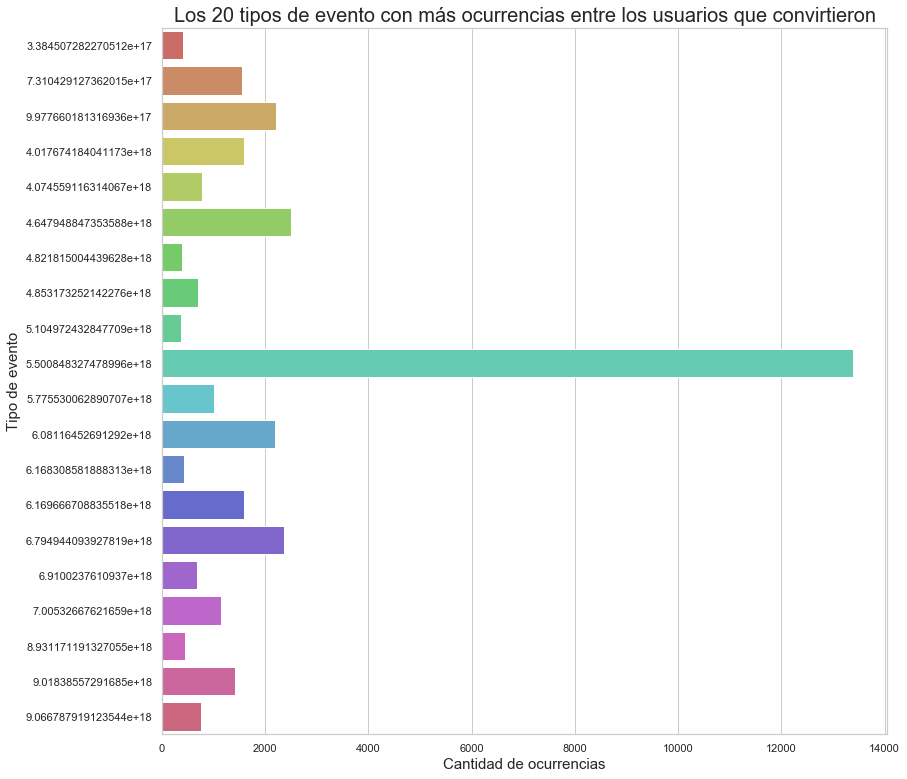

In [13]:
plt.rcParams['figure.figsize'] = (13, 13)

graph = sns.barplot(x= agrup_tipos_evento_top20['cant'], y = agrup_tipos_evento_top20['kind'], orient='h', palette="hls")
graph.set_title("Los 20 tipos de evento con más ocurrencias entre los usuarios que convirtieron", fontsize = 20)
graph.set_xlabel("Cantidad de ocurrencias", fontsize = 15)  #fontdict = font para cambiar la fuente
graph.set_ylabel("Tipo de evento", fontsize = 15)

#### En promedio, ¿cuántos de ellos son atribuidos a Jampp? (no podemos realizar este análisis con los datos brindados)

In [14]:
events.loc[events['kind'].isin(list(agrup_tipos_evento_top20.index)),['attributed']]['attributed'].value_counts()

Series([], Name: attributed, dtype: int64)

## ¿Cuáles fueron los 10 tipos de conversión que más usuarios atrayeron?

In [15]:
installs['cant'] = 1
kinds_group = installs.groupby('kind').agg({'cant':'count'})

In [16]:
kinds_group_ordered = kinds_group.sort_values(by = 'cant', ascending = False).reset_index().loc[:10]

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(9,9))

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

In [18]:
kinds_group_ordered['kind'] = kinds_group_ordered['kind'].astype(str)

Text(0, 0.5, 'Tipo de conversión')

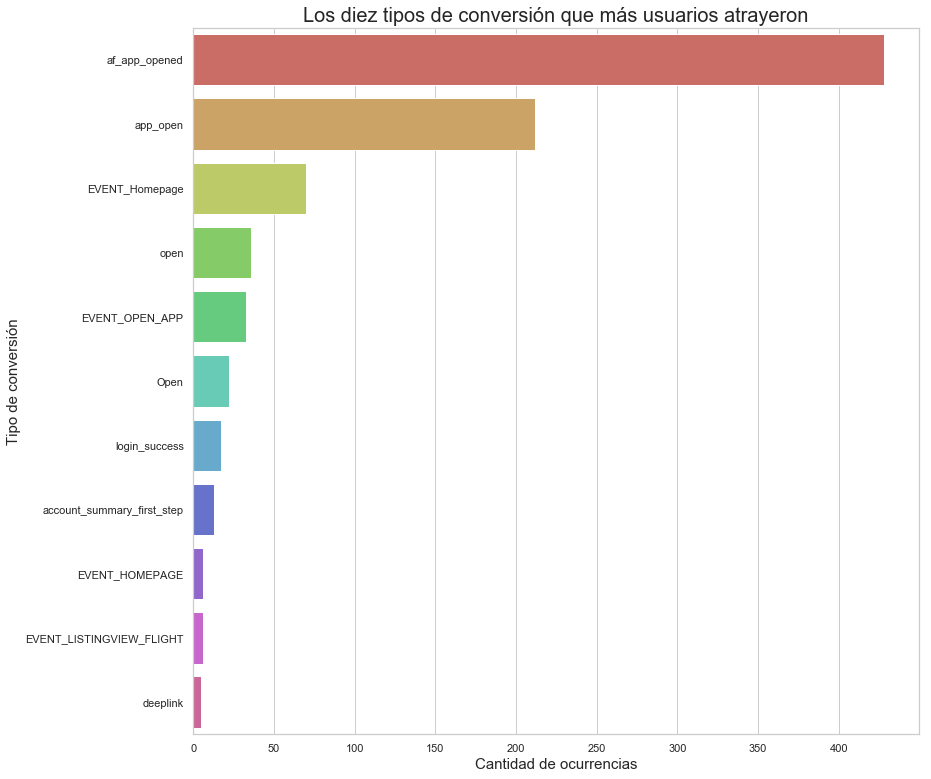

In [19]:
plot = sns.barplot(x= kinds_group_ordered['cant'], y = kinds_group_ordered['kind'], orient='h', palette="hls")
plot.set_title("Los diez tipos de conversión que más usuarios atrayeron", fontsize=20)
plot.set_xlabel("Cantidad de ocurrencias", fontsize=15)
plot.set_ylabel("Tipo de conversión", fontsize = 15)

### ¿Cuántos usuarios convirtieron más de una vez?

In [73]:
installs['cant_instal'] = 1
group_cant_instal = installs.groupby('ref_hash').agg({'cant_instal':'count'}).reset_index().copy()

In [74]:
group_cant_instal['reinstalo'] = group_cant_instal['cant_instal'] > 1

In [75]:
usuarios_multiple_conversiones = list(group_cant_instal.loc[group_cant_instal['reinstalo'] == True, 'ref_hash'])

In [ ]:
fig = {
  "data": [
    {
      "values": group_cant_instal['reinstalo'].value_counts(),
      "text":["Una única vez","Más de una vez"],
      "textinfo":'percent+text',
      "hole": .5,
      "type": "pie",
    "textposition":"inside",
    }],
  "layout": {
        "title":"Distribución en la cantidad de conversiones de los usuarios",
      "showlegend":False,
        "annotations": [
            {
                "font": {
                    "size": 16
                },
                "showarrow": False,
                "text": "¿Cuantas veces<br>convirtieron los<br>usuarios?"
            }
        ]
    }
}
py.offline.iplot(fig)

### Entre los usuarios que convirtieron más de una vez, ¿Cuántos lo hicieron para distintas aplicaciones?

In [76]:
usuarios_multiple_conversiones = installs.loc[installs['ref_hash'].isin(usuarios_multiple_conversiones)]

In [77]:
usuarios_multiple_conversiones = usuarios_multiple_conversiones.groupby('ref_hash').agg({'application_id': 'nunique'})

In [78]:
usuarios_multiple_conversiones['instalo_dist_aplic'] = usuarios_multiple_conversiones['application_id'] > 1

In [79]:
usuarios_multiple_conversiones["instalo_dist_aplic"].value_counts()

False    359
True      20
Name: instalo_dist_aplic, dtype: int64

In [72]:
fig = {
  "data": [
    {
      "values": usuarios_multiple_conversiones["instalo_dist_aplic"].value_counts(),
      "text":["No","Sí"],
      "textinfo":'percent+text',
      "hole": .5,
      "type": "pie",
    "textposition":"outside",
    }],
  "layout": {
      #"colorway":["red","blue"],
        "title":"Usuarios que realizaron múltiples conversiones",
      "showlegend":False,
        "annotations": [
            {
                "font": {
                    "size": 16
                },
                "showarrow": False,
                "text": "¿Convirtieron en<br>distintas<br>aplicaciones?"
            }
        ]
    }
}
py.offline.iplot(fig)